In [1]:
%load_ext autoreload
%autoreload 2

### Graph embedding notebook

Evaluate options for graph embeddings

some useful references:

- https://distill.pub/2021/gnn-intro/
- https://web.stanford.edu/class/cs224w/
- https://pytorch-geometric.readthedocs.io/en/latest/

Structure of the nb:

1) data prep
2) model and training
3) visualization

Next steps:

Train/test split, include Argoverse data

In [2]:
from torch_geometric.data import Data
import numpy as np
from enum import Enum

import networkx as nx
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.data import DataLoader
from torch.utils.data import Subset

import torch
import torch.nn.functional as F
import os
import glob
from sklearn.model_selection import train_test_split

import pickle
from tqdm import tqdm
from graph_creator.MapGraph import MapGraph
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display, HTML

#from graph_creator.plot_graphs import plot_lane_map_advanced, add_actors_to_map, add_actor_edges_to_map
from graph_creator.graph_embeddings import GraphDataset, TrainableGraphGINE, contrastive_loss, augment_graph, get_feature_dimensions, networkx_to_pyg

### Data prep

In [3]:
#graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/*.pkl")
graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_actor_graph_setting_1_50_50_10_20_20_4_4_4_components_nx/*.pkl")

print(len(graph_paths))


90268


In [4]:
# add argoverse data
#argoverse_graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/*.pkl")
argoverse_graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_actor_graph_setting_1_50_50_10_20_20_4_4_4_components_nx/*.pkl")
graph_paths.extend(argoverse_graph_paths)
print(len(graph_paths))

# open one argoverse graph

with open(argoverse_graph_paths[0], 'rb') as f:
    graph = pickle.load(f)
print(graph.nodes(data=True))
graph.edges(data=True)

152938
[('66196', {'lane_id': '300461276', 'lane_ids': ['300461276'], 's': 10.509182331090578, 'xyz': <POINT Z (399.818 1655.687 0)>, 'lon_speed': 0.1635124089729048, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': False, 'is_on_intersection': False}), ('66209', {'lane_id': '300461276', 'lane_ids': ['300461276'], 's': 14.09676401348145, 'xyz': <POINT Z (403.414 1655.586 0)>, 'lon_speed': 4.7093120169978186e-14, 'actor_type': <ActorType.VEHICLE: 'VEHICLE'>, 'lane_change': False, 'is_on_intersection': False})]


OutMultiEdgeDataView([('66196', '66209', {'edge_type': 'following_lead', 'path_length': 3.587581682390871}), ('66209', '66196', {'edge_type': 'following_lead', 'path_length': 3.587581682390871})])

### ML prep

In [5]:
# Train/test split for graph_ds

# Load data
graph_ds = GraphDataset(graph_paths)

indices = np.arange(len(graph_ds))
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=True
)

train_ds = Subset(graph_ds, train_idx)
test_ds = Subset(graph_ds, test_idx)

# Create loaders (overrides earlier train_loader)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

print(f"Train size: {len(train_ds)} | Test size: {len(test_ds)}")
data_loaders = {"train": train_loader, "test": test_loader}

# try out data loading
_item = graph_ds.__getitem__(4320)
_batch = next(iter(train_loader))

Train size: 122350 | Test size: 30588


/home/tmuehlen/.cache/pypoetry/virtualenvs/graph-creator-_1ofKhL9-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Training

In [6]:
# Model setup
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
node_dim, edge_dim = get_feature_dimensions()
model = TrainableGraphGINE(node_dim, edge_dim, 256, 96, 4).to(device)



### evaluate loss one time before training

In [7]:
# get the pre-training loss
from typing import Any


total_losses = {"train": [], "test": [], "lr": [0.02]}

for split in data_loaders:
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(data_loaders[split]):
            batch = batch[0].to(device)
            aug_batch = augment_graph(batch).to(device)
            outputs1 = model(batch)
            outputs2 = model(aug_batch)
            loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
            total_loss += loss.item()
    total_losses[split].append( total_loss / len(data_loaders[split]))

print(total_losses)

100%|██████████| 239/239 [00:13<00:00, 17.49it/s]

{'train': [3.852430086754356], 'test': [3.852490910925127], 'lr': [0.02]}


### The actual training loop

In [8]:
# Training
for i in range(4):
    lr = 0.02*0.75**i
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"loop {i}, Learning rate: {lr}")
    for epoch in range(4):
        total_loss = 0
        for batch in tqdm(train_loader):
            batch = batch[0].to(device)
            aug_batch = augment_graph(batch).to(device)
            optimizer.zero_grad()
            outputs1 = model(batch)
            outputs2 = model(aug_batch)
            loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}')

        total_losses["lr"].append(lr)
        for split in data_loaders:
            total_loss = 0
            with torch.no_grad():
                for batch in data_loaders[split]:
                    batch = batch[0].to(device)
                    aug_batch = augment_graph(batch).to(device)
                    outputs1 = model(batch)
                    outputs2 = model(aug_batch)
                    loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
                    total_loss += loss.item()
            total_losses[split].append( total_loss / len(data_loaders[split]))



loop 0, Learning rate: 0.02
Epoch 0, Loss: 1.0263
Epoch 1, Loss: 0.4153
Epoch 2, Loss: 0.2823
Epoch 3, Loss: 0.2296
loop 1, Learning rate: 0.015
Epoch 0, Loss: 0.1987
Epoch 1, Loss: 0.1760
Epoch 2, Loss: 0.1612
Epoch 3, Loss: 0.1495
loop 2, Learning rate: 0.01125
Epoch 0, Loss: 0.1363
Epoch 1, Loss: 0.1298
Epoch 2, Loss: 0.1235
Epoch 3, Loss: 0.1197
loop 3, Learning rate: 0.0084375
Epoch 0, Loss: 0.1112
Epoch 1, Loss: 0.1070
Epoch 2, Loss: 0.1057
Epoch 3, Loss: 0.1020


### Visualize the loss curves

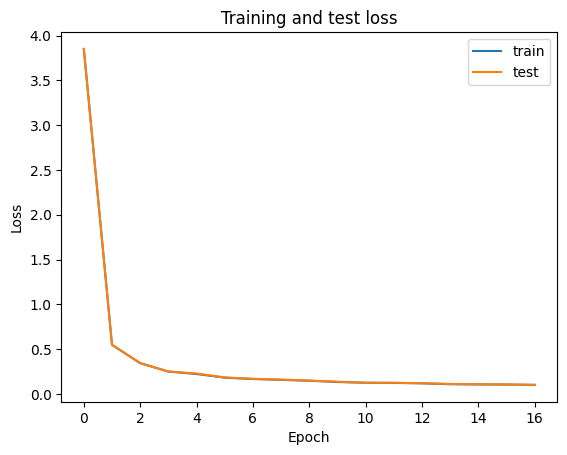

In [10]:
plt.plot(total_losses["train"], label = "train")
plt.plot(total_losses["test"], label = "test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.title("Training and test loss")
plt.savefig("/home/tmuehlen/repos/graph_coverage/article/plots/train_test_graph_embeddings_loss_plot.png")
plt.show()


### Inference on train and test

In [ ]:
# Inference loop
model.eval()
all_embeddings = {"train": [], "test": []}
all_paths = {"train": [], "test": []}

for split in data_loaders:  
    with torch.no_grad():
        for batch in tqdm(data_loaders[split]):  # or test_loader
            all_paths[split].extend(batch[1]) 
            batch = batch[0].to(device)
            outputs = model(batch)
            embeddings = outputs['embeddings']
            all_embeddings[split].append(embeddings.cpu())

# Concatenate all embeddings
final_embeddings = {}
for split in all_embeddings:
    final_embeddings[split] = torch.cat(all_embeddings[split], dim=0)

print(f'Extracted {final_embeddings["train"].shape[0]} embeddings of dimension {final_embeddings["train"].shape[1]}')

### Visualization of embeddings

In [ ]:
# some data preparation
graph_dates_train = [path.split("/")[-1].split("_")[1] for path in all_paths["train"]]
graph_dates_test = [path.split("/")[-1].split("_")[1] for path in all_paths["test"]]
#all_paths
graph_dates = {"train": graph_dates_train, "test": graph_dates_test}

graph_type_train = [path.split("/")[6] for path in all_paths["train"]]
graph_type_test = [path.split("/")[6] for path in all_paths["test"]]
graph_type = {"train": graph_type_train, "test": graph_type_test}

# Convert embeddings to numpy
split = "test"
embeddings_np = final_embeddings[split].numpy()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

pca_df = pd.DataFrame(pca_result)
pca_df.columns = ["pca1", "pca2"]
pca_df["graph_type"] = graph_type[split]
pca_df["graph_path"] = all_paths[split]
pca_df.head()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x="pca1", y="pca2", alpha=0.6, hue="graph_type", legend = True, data=pca_df)
#plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title('PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings_np)
tsne_df = pd.DataFrame(tsne_result)
tsne_df.columns = ["tsne1", "tsne2"]
tsne_df["graph_type"] = graph_type[split]
tsne_df["graph_path"] = all_paths[split]

plt.subplot(1, 2, 2)
sns.scatterplot(x="tsne1", y="tsne2", alpha=0.6, hue="graph_type", legend = True, data=tsne_df)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_pca_tsne_{split}_plot.png")
plt.show()

### Interactive plots for manual cluster selection

In [ ]:
# Create FigureWidget for interactive updates
fig_widget = go.FigureWidget()

# Add PCA scatter
fig_widget.add_scatter(
    x=pca_df['pca1'],
    y=pca_df['pca2'],
    mode='markers',
    marker=dict(
        size=6,
        color=pca_df['graph_type'].map({'carla_w_intersection': 0, 'argoverse_nx': 1}),
        colorscale='Viridis',
    ),
    text=pca_df['graph_type'],
    hovertemplate='<b>Type:</b> %{text}<br><b>Index:</b> %{customdata}<br><b>PCA1:</b> %{x:.2f}<br><b>PCA2:</b> %{y:.2f}<extra></extra>',
    customdata=pca_df.index,
    name='Graph Embeddings'
)

fig_widget.update_layout(
    title='Interactive PCA Plot - Select points to extract data',
    xaxis_title='PC1',
    yaxis_title='PC2',
    height=600,
    width=900,
    dragmode='lasso',
    hovermode='closest'
)

# Store selected data globally
selected_df = pd.DataFrame()

def selection_fn(trace, points, selector):
    """Callback function when points are selected"""
    global selected_df
    if len(points.point_inds) > 0:
        selected_indices = [pca_df.index[i] for i in points.point_inds]
        selected_df = pca_df.loc[selected_indices].copy()
        print(f"\n✓ Selected {len(selected_df)} points")
        print(f"Graph types: {selected_df['graph_type'].value_counts().to_dict()}")
        print(f"\nAccess selected data via: selected_df")
        display(selected_df.head())
    else:
        print("No points selected")

# Attach callback
fig_widget.data[0].on_selection(selection_fn)

# Display the widget
display(HTML("<h3>Use lasso or box select tool to select points</h3>"))
fig_widget


In [ ]:
# Interactive t-SNE plot
fig_widget_tsne = go.FigureWidget()

# Add t-SNE scatter
fig_widget_tsne.add_scatter(
    x=tsne_df['tsne1'],
    y=tsne_df['tsne2'],
    mode='markers',
    marker=dict(
        size=6,
        color=tsne_df['graph_type'].map({'carla_w_intersection': 0, 'argoverse_nx': 1}),
        colorscale='Viridis',
    ),
    text=tsne_df['graph_type'],
    hovertemplate='<b>Type:</b> %{text}<br><b>Index:</b> %{customdata}<br><b>t-SNE1:</b> %{x:.2f}<br><b>t-SNE2:</b> %{y:.2f}<extra></extra>',
    customdata=tsne_df.index,
    name='Graph Embeddings'
)

fig_widget_tsne.update_layout(
    title='Interactive t-SNE Plot - Select points to extract data',
    xaxis_title='t-SNE 1',
    yaxis_title='t-SNE 2',
    height=600,
    width=900,
    dragmode='lasso',
    hovermode='closest'
)

# Store selected data globally
selected_tsne_df = pd.DataFrame()

def selection_fn_tsne(trace, points, selector):
    """Callback function when points are selected"""
    global selected_tsne_df
    if len(points.point_inds) > 0:
        selected_indices = [tsne_df.index[i] for i in points.point_inds]
        selected_tsne_df = tsne_df.loc[selected_indices].copy()
        print(f"\n✓ Selected {len(selected_tsne_df)} points")
        print(f"Graph types: {selected_tsne_df['graph_type'].value_counts().to_dict()}")
        print(f"\nAccess selected data via: selected_tsne_df")
        display(selected_tsne_df.head())
    else:
        print("No points selected")

# Attach callback
fig_widget_tsne.data[0].on_selection(selection_fn_tsne)

# Display the widget
display(HTML("<h3>Use lasso or box select tool to select points</h3>"))
fig_widget_tsne


In [ ]:
selected_tsne_df

In [ ]:
# # Helper function to get full embeddings for selected points
# def get_embeddings_for_selection(selected_dataframe, split="test"):
#     """
#     Get the full 256-dimensional embeddings for selected points
    
#     Parameters:
#     -----------
#     selected_dataframe : pd.DataFrame
#         The dataframe of selected points (selected_df or selected_tsne_df)
#     split : str
#         'train' or 'test' split
    
#     Returns:
#     --------
#     np.ndarray : Array of embeddings for selected points
#     """
#     if len(selected_dataframe) == 0:
#         print("No points selected")
#         return None
    
#     # Get indices in the original embeddings array
#     # The dataframe index corresponds to the position in the test/train set
#     indices = selected_dataframe.index.tolist()
    
#     # Extract embeddings
#     embeddings_np = final_embeddings[split].numpy()
#     selected_embeddings = embeddings_np[indices]
    
#     print(f"Retrieved {selected_embeddings.shape[0]} embeddings of dimension {selected_embeddings.shape[1]}")
#     return selected_embeddings

# # Example usage (after selecting points):
# selected_embeddings = get_embeddings_for_selection(selected_tsne_df, split="test")
# # Or for graph paths:
# # selected_paths = selected_df['graph_path'].tolist()
# print("After selecting points, use:")
# print("  - selected_df or selected_tsne_df to access the selected data")
# print("  - get_embeddings_for_selection(selected_df) to get full 256-dim embeddings")
# print("  - selected_df['graph_path'].tolist() to get file paths")


In [ ]:
# data prep for doing graph plots
os.getcwd()
os.chdir("../..")
os.getcwd()

pca_emb_df = pd.concat([pca_df, pd.DataFrame(embeddings_np)], axis = 1)
pca_emb_df.head(2)

mask_carla = pca_df.graph_type == "carla_w_intersection"
mask_argo = pca_df.graph_type == "argoverse_components_nx"
pca_carla_df = pca_df[mask_carla].reset_index(drop=True)
pca_argo_df = pca_df[mask_argo].reset_index(drop=True)

print(sum(mask_carla), sum(mask_argo))
pca_carla_df.head(2)

# visualizing examples from one cluster selection

In [ ]:
# visualizing examples from one cluster selection
fig, axes = plt.subplots(3, 3, figsize=(30, 15))
axes = axes.flatten()  # Flatten to easily index with loop counter

for i in range(9):
    if selected_tsne_df.graph_type.iloc[i] == "carla_w_intersection":
        graph = selected_tsne_df.graph_path.iloc[i].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn = "_".join(graph.split("_")[:2])
        file_path = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_{graph}.pkl"
        with open(file_path, 'rb') as f:
            nx_graph = pickle.load(f)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn}_map_graph.pickle')
        g_map = g_map.graph
    else:
        # argoverse option
        graph = selected_tsne_df.graph_path.iloc[i].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn = graph[:36]
        file_path = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/graph_{graph}.pkl"
        with open(file_path, 'rb') as f:
            nx_graph = pickle.load(f)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse/{scn}_map_graph.pkl')
        g_map = g_map.graph.graph
    # Create figure with two subplots side by side
    ax = axes[i]
    fig, ax = plot_lane_map_advanced(g_map, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax)
    fig, ax = add_actors_to_map(fig, ax, nx_graph, actor_size=20, show_actor_labels=False)
    fig, ax = add_actor_edges_to_map(fig, ax, nx_graph)
    ax.set_title(f'Scene {scn}')
# Adjust layout and display
plt.tight_layout()
plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_cluster_examples.png")
plt.show()

### Comparing closest embeddings:

In [ ]:
# comparing, no restrictions
for i in range(10):
    try:
        first = pca_emb_df.sample(1)
        pca_emb_df["sq_diff"] = ((pca_emb_df[list(range(256))] - first[list(range(256))].values)**2).sum(axis = 1)

        pca_emb_df.sort_values("sq_diff", inplace=True)

        if first.graph_type.iloc[0] == "carla_w_intersection":
            graph_1 = pca_emb_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_1 = "_".join(graph_1.split("_")[:2])

            file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_{graph_1}.pkl"
            with open(file_path_1, 'rb') as f:
                nx_graph_1 = pickle.load(f)
            g_map_1 = MapGraph()
            g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_1}_map_graph.pickle')
            g_map_1 = g_map_1.graph
        else:
            # argoverse option
            graph_1 = pca_emb_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_1 = graph_1[:36]
            file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/graph_{graph_1}.pkl"
            with open(file_path_1, 'rb') as f:
                nx_graph_1 = pickle.load(f)
            g_map_1 = MapGraph()
            g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse/{scn_1}_map_graph.pkl')
            g_map_1 = g_map_1.graph.graph

        if pca_emb_df.graph_type.iloc[1] == "carla_w_intersection":
            graph_2 = pca_emb_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_2 = "_".join(graph_2.split("_")[:2])
            file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_{graph_2}.pkl"
            with open(file_path_2, 'rb') as f:
                nx_graph_2 = pickle.load(f)
            g_map_2 = MapGraph()
            g_map_2.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_2}_map_graph.pickle')
            g_map_2 = g_map_2.graph
        else:
            # argoverse option
            graph_2 = pca_emb_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_2 = graph_2[:36]
            file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/graph_{graph_2}.pkl"
            with open(file_path_2, 'rb') as f:
                nx_graph_2 = pickle.load(f)
            g_map_2 = MapGraph()
            g_map_2.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse/{scn_2}_map_graph.pkl')
            g_map_2 = g_map_2.graph.graph

        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        fig, ax1 = plot_lane_map_advanced(g_map_1, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # Second scene (right subplot)
        fig, ax2 = plot_lane_map_advanced(g_map_2, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # Adjust layout and display
        plt.tight_layout()
        plt.savefig(f"/home/tmuehlen/repos/graph_coverage/article/plots/graph_embeddings_comparison_plausibility_check_{i}.png")
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


In [ ]:
# comparing argo to argo

for i in range(10):
    first = pca_argo_df.sample(1)
    pca_argo_df["dist"] = (pca_argo_df.pca1 - first.pca1.iloc[0])**2 + (pca_argo_df.pca2 - first.pca2.iloc[0])**2 
    pca_argo_df.sort_values("dist", inplace=True)
    graph_1 = pca_argo_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
    graph_2 = pca_argo_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
    scn_1 = graph_1[:36]
    scn_2 = graph_2[:36]
    file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/graph_{graph_1}.pkl"
    with open(file_path_1, 'rb') as f:
        nx_graph_1 = pickle.load(f)
    file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_components_nx/graph_{graph_2}.pkl"
    with open(file_path_2, 'rb') as f:
        nx_graph_2 = pickle.load(f)
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    # First scene (left subplot)
    g_map = MapGraph()
    g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse/{scn_1}_map_graph.pkl')
    fig, ax1 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
    fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
    fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
    ax1.set_title(f'Scene {scn_1}')
    # Second scene (right subplot)
    g_map = MapGraph()
    g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse/{scn_2}_map_graph.pkl')
    fig, ax2 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
    fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
    fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
    ax2.set_title(f'Scene {scn_2}')
    # Adjust layout and display
    plt.tight_layout()
    plt.show()


In [ ]:
# comparing carla to carla

for i in range(10):
    try:
        first = pca_carla_df.sample(1)
        pca_carla_df["dist"] = (pca_carla_df.pca1 - first.pca1.iloc[0])**2 + (pca_carla_df.pca2 - first.pca2.iloc[0])**2 
        pca_carla_df.sort_values("dist", inplace=True)
        graph_1 = pca_carla_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        graph_2 = pca_carla_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn_1 = "_".join(graph_1.split("_")[:2])
        scn_2 = "_".join(graph_2.split("_")[:2])
        print(graph_1, scn_1)
        print(graph_2, scn_2)
        pca_df.head(2)
        file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_{graph_1}.pkl"
        with open(file_path_1, 'rb') as f:
            nx_graph_1 = pickle.load(f)
        file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla_w_intersection/graph_{graph_2}.pkl"
        with open(file_path_2, 'rb') as f:
            nx_graph_2 = pickle.load(f)
        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_1}_map_graph.pickle')
        fig, ax1 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # Second scene (right subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_2}_map_graph.pickle')
        fig, ax2 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # Adjust layout and display
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")
